# Machine Learning for Gold Recovery

## Table of Contents <a id='back'></a>

* [1. Introduction](#intro)
* [2. Initiation](#init)
* [3. Data Overview](#overview)
* [4. Data Distribution Analysis](#eda)
	* [4.1. Changes in Metal Concentration Distribution in Each Stage](#eda1)
	* [4.2. Changes in Metal Concentration Statistics in Each Stage](#eda2)
	* [4.3. Comparing Feed Particle Size Distribution in the Training and Testing Dataset](#eda3)
	* [4.4. Comparing Total Concentration for All Substances in All Stages for Training and Testing Dataset](#eda4)
* [5. Model Development](#train)
	* [5.1. sMAPE Function](#1)
	* [5.2. Defining Features and Targets](#2)
	* [5.3. Build Model](#3)
* [6. General Conclusion](#end)
* [7. Appendix](#index)

## 1. Introduction <a id='intro'></a>

### 1.1. Project Description

Prepare a prototype of a machine learning model for Zyfra. This company operates in the field of developing efficient solutions for heavy industries.

The model you create should be able to predict the amount of gold extracted or obtained from gold ore. There is available data related to the process of extraction and refining of gold ore that you can use.

In the future, this model is expected to help create a more efficient production process and eliminate parameters that do not yield profits.

### 1.2. Objectives

Develop a machine learning process to predict rougher output recovery and final output recovery from gold extraction process.

### 1.3. Dataset Description

#### Dataset

We will use these 3 datasets.
* gold_recovery_train.csv
* gold_recovery_test.csv
* gold_recovery_full.csv

This data is indexed according to the date and time of acquisition (using the "date" feature). Regarding time, parameters that are located adjacent to each other generally have similar values.

Some parameters may not be available because their measurement and/or calculation were done after a while That's why some features that exist in the training set may not be present in the test set. The test set also does not contain any target values.

The source dataset includes both the training and test sets with all their features.

#### Variables

The features are named using this method:
\[stage\].\[parameter_type\].\[parameter_name\]

For example: rougher.input.feed_ag

The values for `stage` consists of:
1. rougher - floatation
2. primary_cleaner - first refinement
3. secondary_cleaner - second refinement
4. final - final characterictics

The values for `parameter_type` consists of:
* input - raw material
* output - product
* state - current stage characteristics
* calculation - characteristics calculation

### 1.4. Methodology

The steps for this research are:
1. Prepare the data
 1. Open the file and study the data.
 2. Check if the gold recovery has been calculated correctly. Using the training set, calculate the recovery for the feature rougher.output.recovery. Find the Mean Absolute Error (MAE) between your calculation and the feature value. Show what you have found.
 3. Analyze the features that are not available in the test set. What are these parameters? What type of parameters are they?
 4. Perform data preprocessing.

2. Analyze the data
 1. Make notes on how the concentration of metals (Au, Ag, Pb) changes depending on the purification stage.
 2. Compare the distribution of feed particle size in the training set and the test set. If the distribution varies significantly, the model evaluation will be incorrect.
 3. Consider the total concentration of all substances in different stages: raw feed, rougher concentration, and final concentration. Do you see any abnormal values in the total distribution? If yes, do you need to remove these values from both samples? Explain what you have found and eliminate the anomalies.

3. Build the model
 1. Create a function to calculate the final sMAPE (symmetric Mean Absolute Percentage Error) value.
 2. Train different models and evaluate these models using cross-validation. Choose the best model and test it using the test sample. Show what you have found.

[back to table of contents](#back)

## 2. Initiation <a id='init'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler

In [2]:
df_train = pd.read_csv('datasets/gold_recovery_train.csv')
df_test = pd.read_csv('datasets/gold_recovery_test.csv')
df_full = pd.read_csv('datasets/gold_recovery_full.csv')

np.random.seed(12345)
state = np.random.RandomState(12345)

[back to table of contents](#back)

## 3. Data Overview <a id='overview'></a>

In [3]:
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [5]:
print(f'Number of duplicated columns in training dataset = {df_train.duplicated().sum()}')

Number of duplicated columns in training dataset = 0


In [6]:
print(f'Maximum proportion of missing values per column for training dataset = \
{(df_train.isna().sum().max()/len(df_train)*100):.2f} %')

Maximum proportion of missing values per column for training dataset = 15.26 %


In [7]:
df_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


In [8]:
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [10]:
print(f'Number of duplicated columns in testing dataset = {df_test.duplicated().sum()}')

Number of duplicated columns in testing dataset = 0


In [11]:
print(f'Maximum proportion of missing values per column for testing dataset = \
{(df_test.isna().sum().max()/len(df_test)*100):.2f} %')

Maximum proportion of missing values per column for testing dataset = 6.03 %


In [12]:
df_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


In [13]:
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [14]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [15]:
print(f'Number of duplicated columns in all dataset = {df_test.duplicated().sum()}')

Number of duplicated columns in all dataset = 0


In [16]:
print(f'Maximum proportion of missing values per column for all dataset = \
{(df_full.isna().sum().max()/len(df_full)*100):.2f} %')

Maximum proportion of missing values per column for all dataset = 13.73 %


In [17]:
df_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


In [18]:
train_test_diff = sorted(list(set(df_train.columns).difference(df_test.columns)))
train_test_diff

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [19]:
df_train[train_test_diff].dtypes

final.output.concentrate_ag                           float64
final.output.concentrate_au                           float64
final.output.concentrate_pb                           float64
final.output.concentrate_sol                          float64
final.output.recovery                                 float64
final.output.tail_ag                                  float64
final.output.tail_au                                  float64
final.output.tail_pb                                  float64
final.output.tail_sol                                 float64
primary_cleaner.output.concentrate_ag                 float64
primary_cleaner.output.concentrate_au                 float64
primary_cleaner.output.concentrate_pb                 float64
primary_cleaner.output.concentrate_sol                float64
primary_cleaner.output.tail_ag                        float64
primary_cleaner.output.tail_au                        float64
primary_cleaner.output.tail_pb                        float64
primary_

Training dataset consists of 16860 rows and 87 columns.

Testing dataset consists of 5856 rows and 53 columns.

Full dataset is composed of training and testing dataset combined, there are 22716 rows and 87 columns.

The variables not available in testing dataset but available in training dataset are output from each step of the process and calculation variables. All of which have continuous numerical values.

For all the dataset, we will assume that all data that represent the same type of output is in the same units.

All of the missing data will be treated with listwise deletion as it requires all the variable to be present for our model. There is no duplicated observation or redundant column.

In [20]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)
df_full.dropna(inplace=True)

We will do sanity check on whether the gold recovery has been calculated correctly. We will use the Mean Absolute Error (MAE) between the calculated value using the formula below and the feature value for `rougher.output.recovery` on training dataset.

<img src="https://practicum-content.s3.us-west-1.amazonaws.com:443/resources/10.3.2.3ID_1673511227.png" alt="image" class="image image_expandable" style="">

* C - the percentage of gold in the concentrate immediately after the flotation process (to find the recovery of rougher concentrate)/after refining (to find the recovery of final concentrate)
* F - the percentage of gold in the feed before the flotation process (to find the recovery of rougher concentrate)/in the concentrate immediately after the flotation process (to find the recovery of final concentrate)
* T - the percentage of gold in the rougher tailings, immediately after the flotation process (to find the recovery of rougher concentrate)/after refining (to find the recovery of final concentrate)

In [21]:
def rec_calc(C,F,T):
    recovery = ((C*(F-T))/(F*(C-T))*100)
    return recovery

In [22]:
recovery_rougher = rec_calc(df_train['rougher.output.concentrate_au'],df_train['rougher.input.feed_au'],df_train['rougher.output.tail_au'])

In [23]:
mean_absolute_error(df_train['rougher.output.recovery'], recovery_rougher)

9.460144184559453e-15

The mean absolute error between the recovery from manual calculation and recovery from the dataset for rougher/floatation process is very small. Therefore the recovery from the dataset is accurate.

[back to table of contents](#back)

## 4. Data Distribution Analysis <a id='eda'></a>

### 4.1. Changes in Metal Concentration Distribution in Each Stage <a id='eda1'></a>

In [24]:
au = ['rougher.input.feed_au','rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au']
ag = ['rougher.input.feed_ag','rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']
pb = ['rougher.input.feed_pb','rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']

In [25]:
def hist_plot(cols):
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,4), sharey=True)
    sns.despine(left=True)
    for i in range(len(cols)):
        sns.histplot(df_train[cols[i]], kde=True, ax=ax[i])
        ax[i].set_xlabel(cols[i])
    plt.show()

AU Concentrate Distribution in Each Step


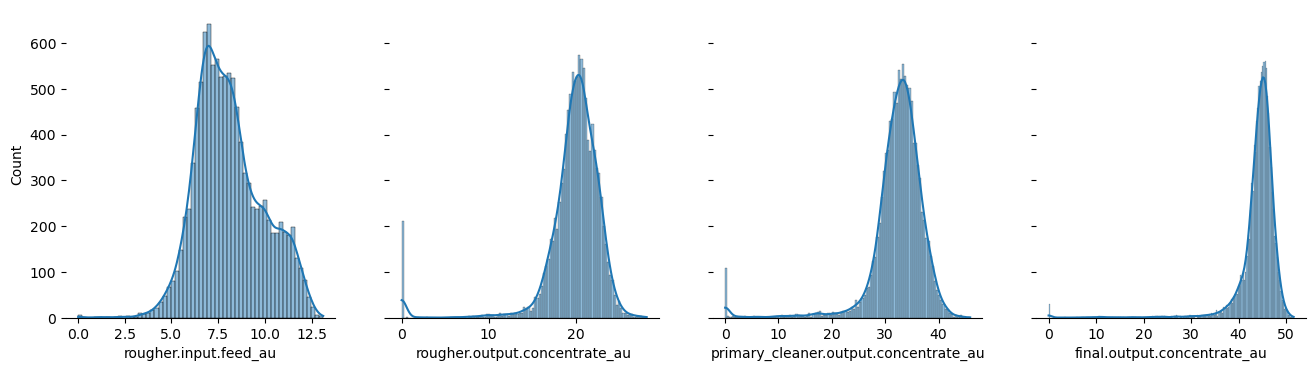

In [26]:
print('AU Concentrate Distribution in Each Step')
hist_plot(au)

AG Concentrate Distribution in Each Step


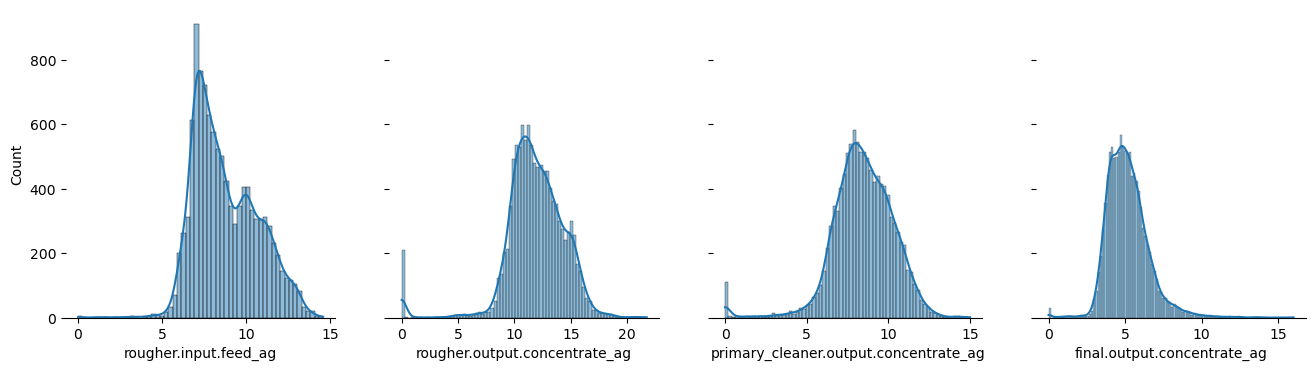

In [27]:
print('AG Concentrate Distribution in Each Step')
hist_plot(ag)

In [28]:
au = ['rougher.input.feed_au','primary_cleaner.output.tail_au','secondary_cleaner.output.tail_au','final.output.tail_au']
ag = ['rougher.input.feed_ag','primary_cleaner.output.tail_ag','secondary_cleaner.output.tail_ag','final.output.tail_ag']
pb = ['rougher.input.feed_pb','primary_cleaner.output.tail_pb','secondary_cleaner.output.tail_pb','final.output.tail_pb']

cols = au + ag + pb

PB Concentrate Distribution in Each Step


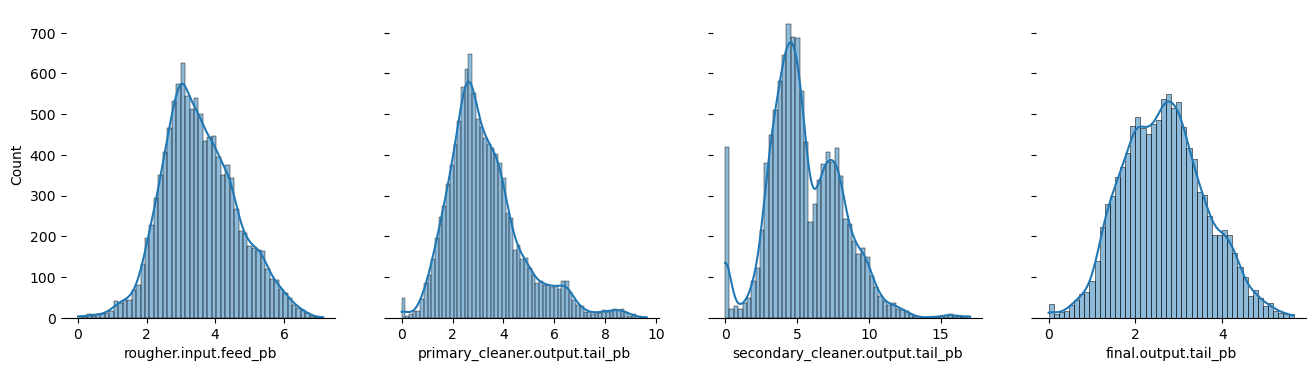

In [29]:
print('PB Concentrate Distribution in Each Step')
hist_plot(pb)

The distribution of metals seem to follow normal distribution. Therefore, mean and median can be used to represent those values.

[back to table of contents](#back)

###  4.2. Changes in Metal Concentration Statistics in Each Stage <a id='eda2'></a>

####  Mean

In [30]:
rougher_in_mean = pd.DataFrame(df_train[['rougher.input.feed_au',
                                           'rougher.input.feed_ag',
                                           'rougher.input.feed_pb']].mean())
rougher_out_mean = pd.DataFrame(df_train[['rougher.output.concentrate_au',
                                           'rougher.output.concentrate_ag',
                                           'rougher.output.concentrate_pb']].mean())
primary_out_mean = pd.DataFrame(df_train[['primary_cleaner.output.concentrate_au',
                                           'primary_cleaner.output.concentrate_ag',
                                           'primary_cleaner.output.concentrate_pb']].mean())
secondary_out_mean = pd.DataFrame(df_train[['final.output.concentrate_au',
                                           'final.output.concentrate_ag',
                                           'final.output.concentrate_pb']].mean())

rougher_in_mean.columns = ['rougher_in_mean']
rougher_out_mean.columns = ['rougher_out_mean']
primary_out_mean.columns = ['primary_out_mean']
secondary_out_mean.columns = ['secondary_out_mean']

rougher_in_mean.index = ['au','ag','pb']
rougher_out_mean.index = ['au','ag','pb']
primary_out_mean.index = ['au','ag','pb']
secondary_out_mean.index = ['au','ag','pb']

concentrate_mean = rougher_in_mean.join(rougher_out_mean).join(primary_out_mean).join(secondary_out_mean)

In [31]:
concentrate_mean

,rougher_in_mean,rougher_out_mean,primary_out_mean,secondary_out_mean
au,8.107739,19.776788,32.380986,44.131636
ag,8.773065,11.841982,8.437251,5.156333
pb,3.554777,7.612323,9.574924,10.172687


In [32]:
concentrate_mean_diff = concentrate_mean.diff(axis=1)
concentrate_mean_diff

,rougher_in_mean,rougher_out_mean,primary_out_mean,secondary_out_mean
au,NaN,11.669049,12.604198,11.750650
ag,NaN,3.068917,-3.404731,-3.280918
pb,NaN,4.057546,1.962601,0.597763


In [33]:
concentrate_mean_pct_change = concentrate_mean.pct_change(axis=1) * 100
concentrate_mean_pct_change

,rougher_in_mean,rougher_out_mean,primary_out_mean,secondary_out_mean
au,NaN,143.924816,63.732283,36.288735
ag,NaN,34.981128,-28.751361,-38.886101
pb,NaN,114.143464,25.781894,6.243010


In [34]:
concentrate_mean_T = concentrate_mean.T.reset_index()

In [35]:
def hist_plot(col,i,j):
    sns.histplot(df_train[col], kde=True, ax=ax[i,j])
    ax[i,j].set_xlabel(col)

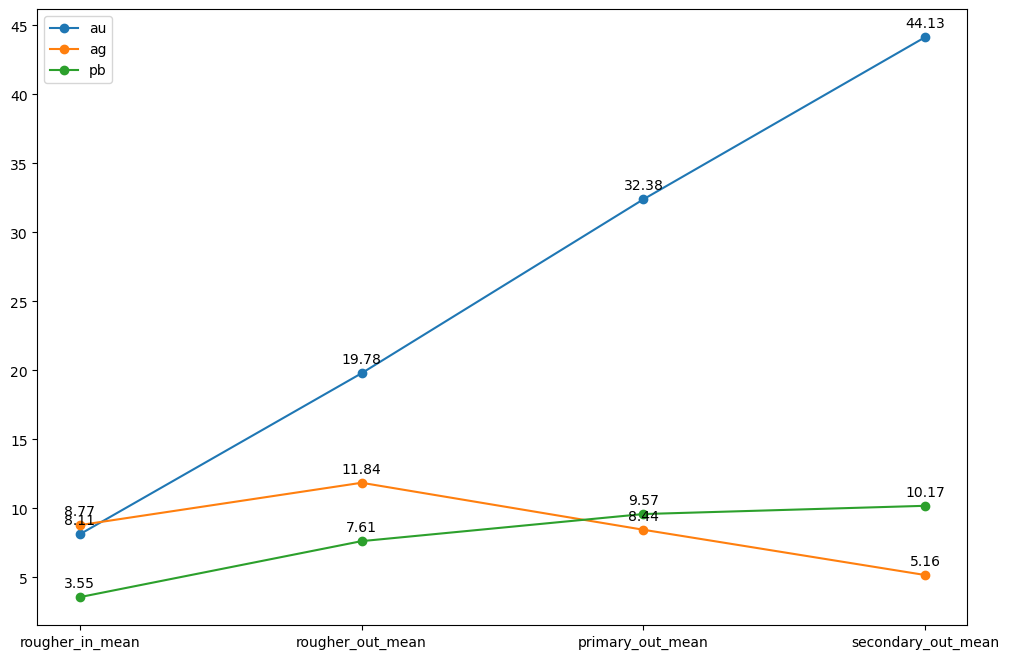

In [36]:
plt.figure(figsize=(12,8))
a = plt.plot(concentrate_mean_T['index'], concentrate_mean_T[['au','ag','pb']], 'o-')
for x, y in (zip(concentrate_mean_T['index'], concentrate_mean_T[['au','ag','pb']].values.tolist())):
    for yi in y:
        plt.annotate(f'{yi:.2f}', xy=(x, yi), xytext=(0,10), textcoords='offset points',ha='center',va='center')
plt.legend(['au','ag','pb'])
plt.show()

<div class="alert alert-success">
<b>Chamdani's comment v.1</b> <a class="tocSkip"></a>

Bagus, semua berjalan lancar.

</div>

####  Median

In [37]:
rougher_in_median = pd.DataFrame(df_train[['rougher.input.feed_au',
                                           'rougher.input.feed_ag',
                                           'rougher.input.feed_pb']].median())
rougher_out_median = pd.DataFrame(df_train[['rougher.output.concentrate_au',
                                           'rougher.output.concentrate_ag',
                                           'rougher.output.concentrate_pb']].median())
primary_out_median = pd.DataFrame(df_train[['primary_cleaner.output.concentrate_au',
                                           'primary_cleaner.output.concentrate_ag',
                                           'primary_cleaner.output.concentrate_pb']].median())
secondary_out_median = pd.DataFrame(df_train[['final.output.concentrate_au',
                                           'final.output.concentrate_ag',
                                           'final.output.concentrate_pb']].median())

rougher_in_median.columns = ['rougher_in_median']
rougher_out_median.columns = ['rougher_out_median']
primary_out_median.columns = ['primary_out_median']
secondary_out_median.columns = ['secondary_out_median']

rougher_in_median.index = ['au','ag','pb']
rougher_out_median.index = ['au','ag','pb']
primary_out_median.index = ['au','ag','pb']
secondary_out_median.index = ['au','ag','pb']

concentrate_median = rougher_in_median.join(rougher_out_median).join(primary_out_median).join(secondary_out_median)

In [38]:
concentrate_median

,rougher_in_median,rougher_out_median,primary_out_median,secondary_out_median
au,7.865763,20.262237,33.017232,44.802196
ag,8.366434,11.797794,8.436412,4.999314
pb,3.444287,7.708693,9.919856,10.347530


In [39]:
concentrate_median_diff = concentrate_median.diff(axis=1)
concentrate_median_diff

,rougher_in_median,rougher_out_median,primary_out_median,secondary_out_median
au,NaN,12.396473,12.754995,11.784964
ag,NaN,3.431360,-3.361382,-3.437098
pb,NaN,4.264406,2.211164,0.427674


In [40]:
concentrate_median_pct_change = concentrate_median.pct_change(axis=1) * 100
concentrate_median_pct_change

,rougher_in_median,rougher_out_median,primary_out_median,secondary_out_median
au,NaN,157.600387,62.949591,35.693374
ag,NaN,41.013410,-28.491613,-40.741227
pb,NaN,123.810994,28.684027,4.311292


In [41]:
concentrate_median_T = concentrate_median.T.reset_index()

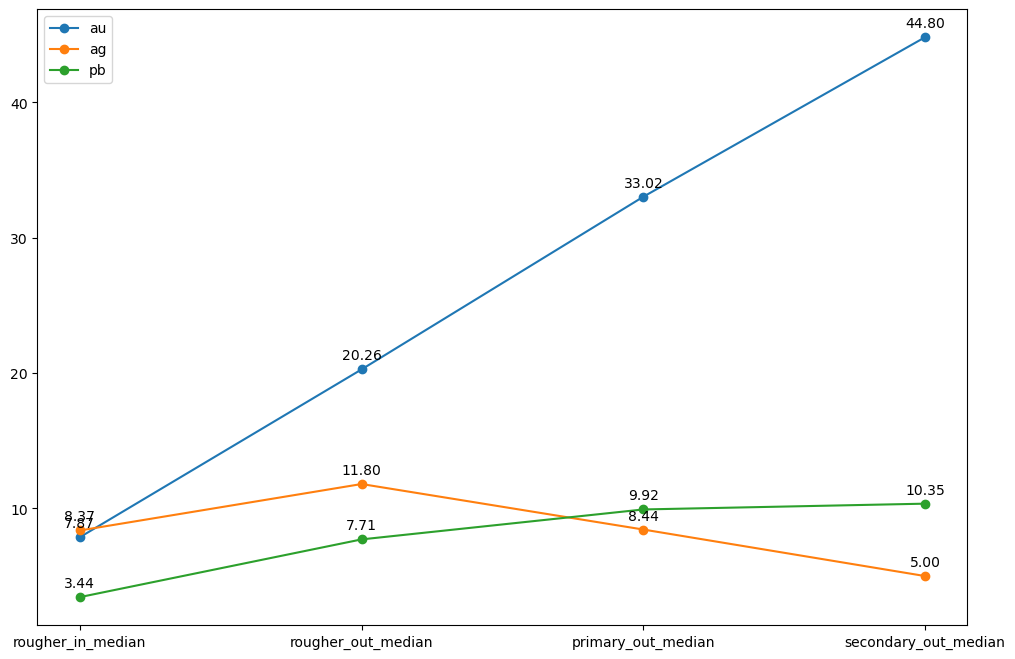

In [42]:
plt.figure(figsize=(12,8))
a = plt.plot(concentrate_median_T['index'], concentrate_median_T[['au','ag','pb']], 'o-')
for x, y in (zip(concentrate_median_T['index'], concentrate_median_T[['au','ag','pb']].values.tolist())):
    for yi in y:
        plt.annotate(f'{yi:.2f}', xy=(x, yi), xytext=(0,10), textcoords='offset points',ha='center',va='center')
plt.legend(['au','ag','pb'])
plt.show()

By plotting the mean or median of the metal concentration, we can see that the concentration of Au increases steadily by 11-12% in each stage until it reaches the final stage. Whereas the concentration of Ag increases after the first step (floatation) and decreases after. For Pb, the concentration increases in each stage, but the increase is getting smaller as the process continues.

[back to table of contents](#back)

###  4.3. Comparing Feed Particle Size Distribution in the Training and Testing Dataset <a id='eda3'></a>

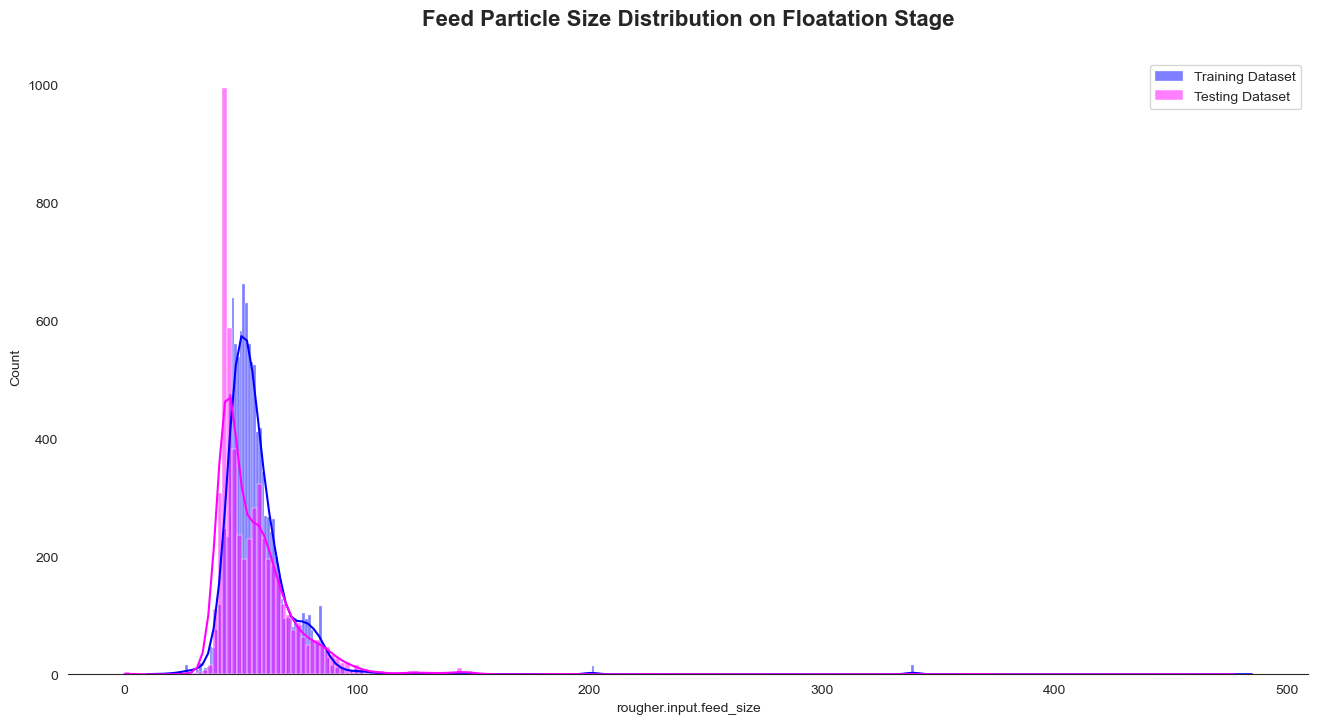

In [43]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(16,8))
sns.despine(left=True)
sns.histplot(df_train['rougher.input.feed_size'],kde=True,color='blue',alpha=0.5,label='Training Dataset')
sns.histplot(df_test['rougher.input.feed_size'],kde=True,color='magenta',alpha=0.5,label='Testing Dataset')
ax.set_title('Feed Particle Size Distribution on Floatation Stage',y=1.04,fontsize=16,fontweight=700)
ax.legend()
plt.show()

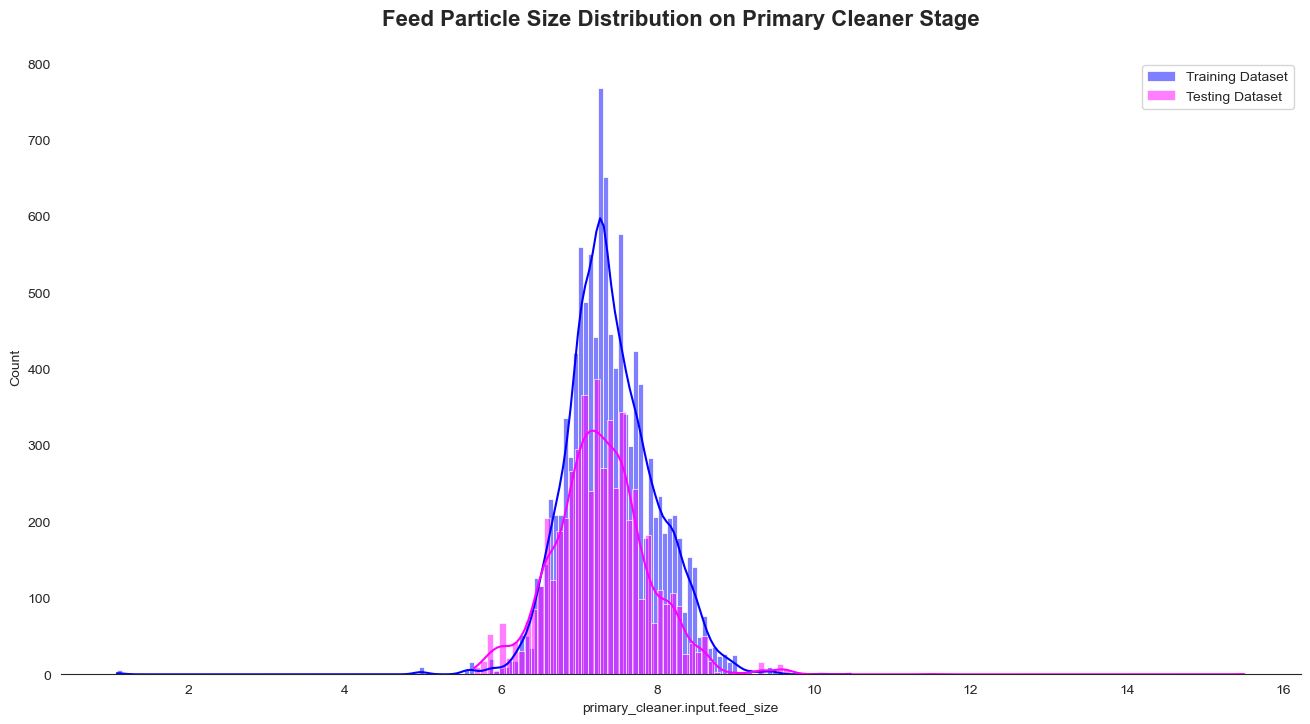

In [44]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(16,8))
sns.despine(left=True)
sns.histplot(df_train['primary_cleaner.input.feed_size'],kde=True,color='blue',alpha=0.5,label='Training Dataset')
sns.histplot(df_test['primary_cleaner.input.feed_size'],kde=True,color='magenta',alpha=0.5,label='Testing Dataset')
ax.set_title('Feed Particle Size Distribution on Primary Cleaner Stage',y=1.04,fontsize=16,fontweight=700)
ax.legend()
plt.show()

Remove feed size outliers in training and testing dataset.

In [45]:
def calc_bound(col):
    iqr = st.iqr(col)
    lower_bound = col.quantile(0.25) - 1.5*iqr
    upper_bound = col.quantile(0.75) + 1.5*iqr
    return lower_bound, upper_bound

In [46]:
lb_r_train, ub_r_train = calc_bound(df_train['rougher.input.feed_size'])
lb_r_test, ub_r_test = calc_bound(df_test['rougher.input.feed_size'])
lb_pc_train, ub_pc_train = calc_bound(df_train['primary_cleaner.input.feed_size'])
lb_pc_test, ub_pc_test = calc_bound(df_test['primary_cleaner.input.feed_size'])

print('Rougher input feed size for training dataset has lower bound =', lb_r_train,'and upper bound =', ub_r_train)
print('Rougher input feed size for testing dataset has lower bound =', lb_r_test,'and upper bound =', ub_r_test)
print('Primary cleaner input feed size for training dataset has lower bound =', lb_pc_train,'and upper bound =', ub_pc_train)
print('Primary cleaner input feed size for testing dataset has lower bound =', lb_pc_test,'and upper bound =', ub_pc_test)

Rougher input feed size for training dataset has lower bound = 28.80044943542217 and upper bound = 81.05856226137905
Rougher input feed size for testing dataset has lower bound = 16.23693820851097 and upper bound = 90.0418121938666
Primary cleaner input feed size for training dataset has lower bound = 5.965000867843628 and upper bound = 8.804999113082886
Primary cleaner input feed size for testing dataset has lower bound = 5.831250444517993 and upper bound = 8.66124958070131


In [47]:
df_train_no_outliers = df_train[
    (df_train["rougher.input.feed_size"] > lb_r_train) & (df_train["rougher.input.feed_size"] < ub_r_train) &
    (df_train["primary_cleaner.input.feed_size"] > lb_pc_train) & (df_train["primary_cleaner.input.feed_size"] < ub_pc_train)]
df_test_no_outliers = df_test[
    (df_test["rougher.input.feed_size"] > lb_r_test) & (df_test["rougher.input.feed_size"] < ub_r_test) &
    (df_test["primary_cleaner.input.feed_size"] > lb_pc_test) & (df_test["primary_cleaner.input.feed_size"] < ub_pc_test)]

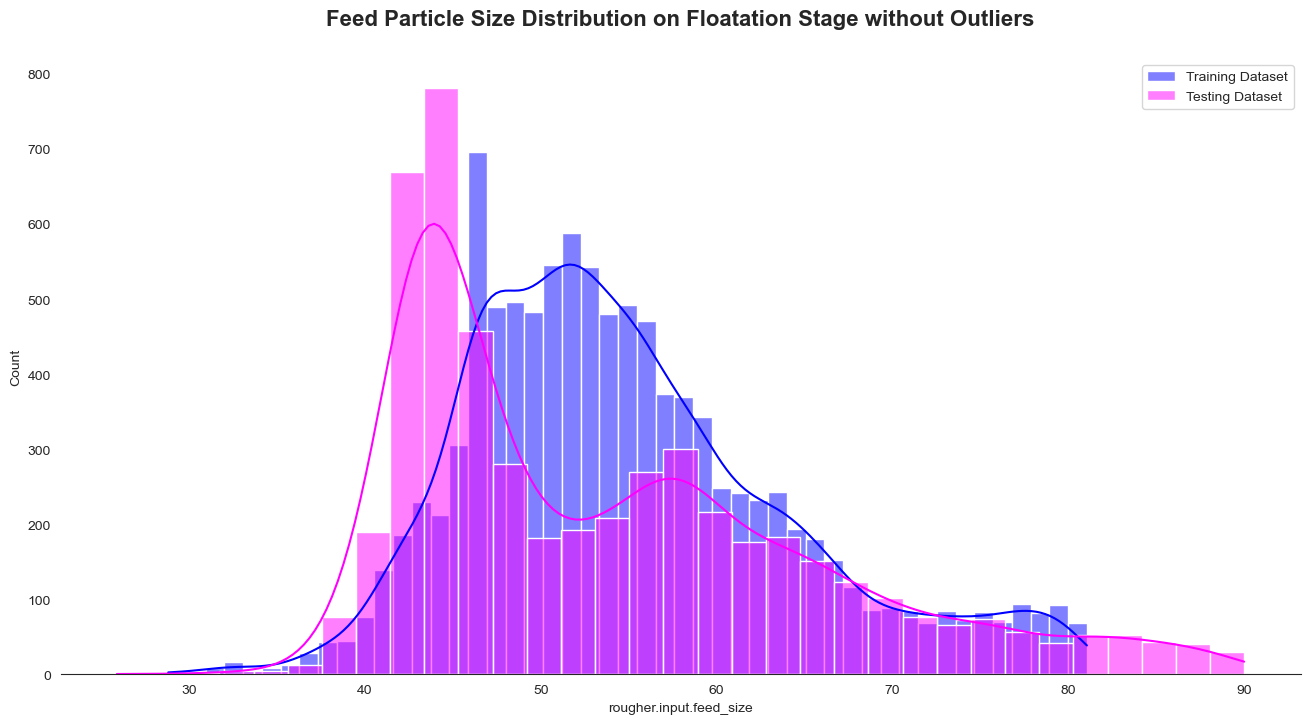

In [48]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(16,8))
sns.despine(left=True)
sns.histplot(df_train_no_outliers['rougher.input.feed_size'],kde=True,color='blue',alpha=0.5,label='Training Dataset')
sns.histplot(df_test_no_outliers['rougher.input.feed_size'],kde=True,color='magenta',alpha=0.5,label='Testing Dataset')
ax.set_title('Feed Particle Size Distribution on Floatation Stage without Outliers',y=1.04,fontsize=16,fontweight=700)
ax.legend()
plt.show()

Conduct two-tailed T-test for these hypothesis with alpha = 0.05 to find whether the two data has similar statistics:
* H0: `rougher.input.feed_size` mean between training dataset and testing dataset is the same.
* H1: `rougher.input.feed_size` mean between training dataset and testing dataset is not the same.

In [49]:
alpha = 0.05
results = st.ttest_ind(
    df_train_no_outliers['rougher.input.feed_size'].sample(n=200,random_state=state),
    df_test_no_outliers['rougher.input.feed_size'].sample(n=200,random_state=state))

if results.pvalue < alpha:
    print('There is enough evidence to reject H0.\nrougher.input.feed_size mean between training dataset and testing dataset is not the same.')
else:
    print('There is not enough evidence to reject H0.\nrougher.input.feed_size mean between training dataset and testing dataset is the same.')

There is not enough evidence to reject H0.
rougher.input.feed_size mean between training dataset and testing dataset is the same.


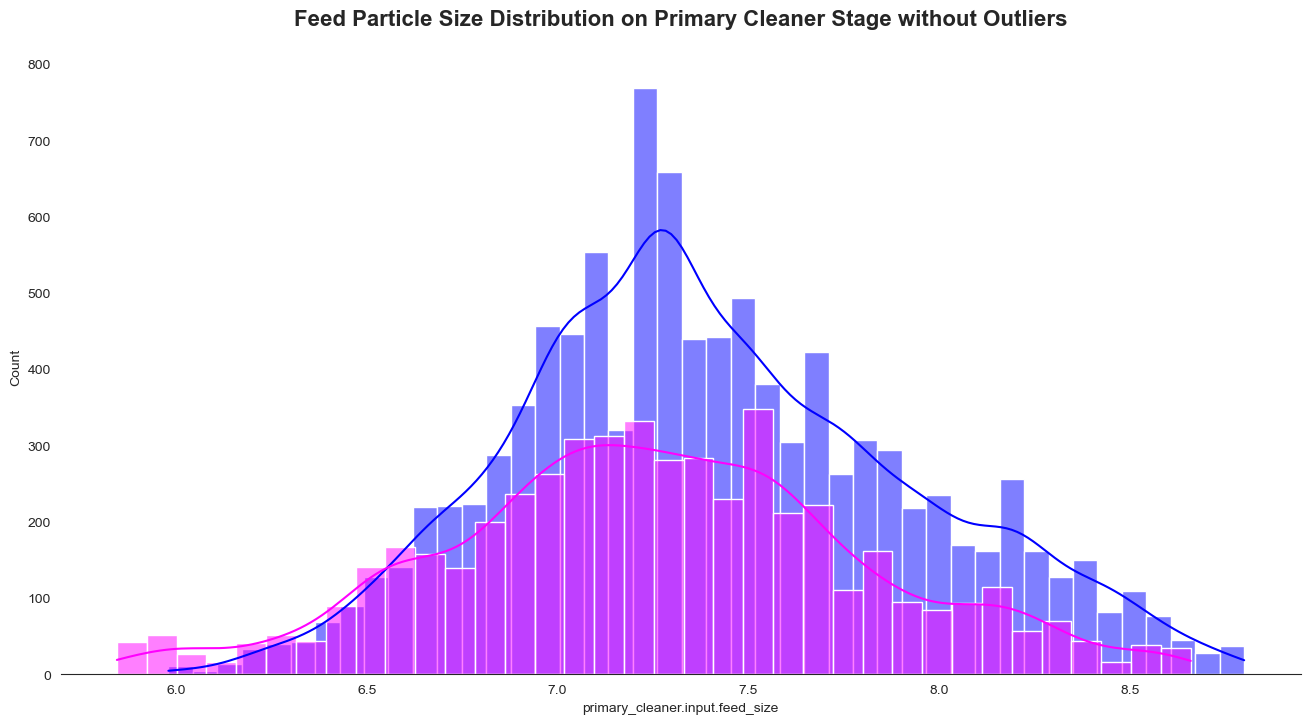

In [50]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(16,8))
sns.despine(left=True)
sns.histplot(df_train_no_outliers['primary_cleaner.input.feed_size'],kde=True,color='blue',alpha=0.5,label='Training Dataset')
sns.histplot(df_test_no_outliers['primary_cleaner.input.feed_size'],kde=True,color='magenta',alpha=0.5,label='Testing Dataset')
ax.set_title('Feed Particle Size Distribution on Primary Cleaner Stage without Outliers',y=1.04,fontsize=16,fontweight=700)
plt.show()

Conduct two-tailed T-test for these hypothesis with alpha = 0.05 to find whether the two data has similar statistics:
* H0: `primary_cleaner.input.feed_size` mean between training dataset and testing dataset is the same.
* H1: `primary_cleaner.input.feed_size` mean between training dataset and testing dataset is not the same.

In [51]:
alpha = 0.05
results = st.ttest_ind(
    df_train_no_outliers['primary_cleaner.input.feed_size'].sample(n=200,random_state=state),
    df_test_no_outliers['primary_cleaner.input.feed_size'].sample(n=200,random_state=state))

if results.pvalue < alpha:
    print('There is enough evidence to reject H0.\nprimary_cleaner.input.feed_size mean between training dataset and testing dataset is not the same.')
else:
    print('There is not enough evidence to reject H0.\nprimary_cleaner.input.feed_size mean between training dataset and testing dataset is the same.')

There is enough evidence to reject H0.
primary_cleaner.input.feed_size mean between training dataset and testing dataset is not the same.


By removing feed particle size outliers, we get a more representative values for the variable. From the graphs above, we can see that the distribution are quite similar between feed size for training and testing dataset.

[back to table of contents](#back)

###  4.4. Comparing Total Concentration for All Substances in All Stages for Training and Testing Dataset <a id='eda4'></a>

Consider the total concentration of all substances in different stages: raw feed, rougher concentration, and final concentration. Do you see any abnormal values in the total distribution? If yes, do you need to remove these values from both samples? Explain what you have found and eliminate the anomalies.

#### Training Dataset

In [52]:
df_train_no_outliers.loc[:,'rougher.input.feed_total'] = df_train_no_outliers['rougher.input.feed_au'] + \
                                                    df_train_no_outliers['rougher.input.feed_ag'] + \
                                                    df_train_no_outliers['rougher.input.feed_pb'] + \
                                                    df_train_no_outliers['rougher.input.feed_sol']
df_train_no_outliers.loc[:,'rougher.output.concentrate_total'] = df_train_no_outliers['rougher.output.concentrate_au'] + \
                                                            df_train_no_outliers['rougher.output.concentrate_ag'] + \
                                                            df_train_no_outliers['rougher.output.concentrate_pb'] + \
                                                            df_train_no_outliers['rougher.output.concentrate_sol']
df_train_no_outliers.loc[:,'primary_cleaner.output.concentrate_total'] = df_train_no_outliers['primary_cleaner.output.concentrate_au'] + \
                                                                    df_train_no_outliers['primary_cleaner.output.concentrate_au'] + \
                                                                    df_train_no_outliers['primary_cleaner.output.concentrate_pb'] + \
                                                                    df_train_no_outliers['primary_cleaner.output.concentrate_sol']
df_train_no_outliers.loc[:,'final.output.concentrate_total'] = df_train_no_outliers['final.output.concentrate_au'] + \
                                                        df_train_no_outliers['final.output.concentrate_ag'] + \
                                                        df_train_no_outliers['final.output.concentrate_pb'] + \
                                                        df_train_no_outliers['final.output.concentrate_sol']

C:\Users\Anglo\AppData\Local\Temp\ipykernel_5836\382947113.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_no_outliers.loc[:,'rougher.input.feed_total'] = df_train_no_outliers['rougher.input.feed_au'] + \
C:\Users\Anglo\AppData\Local\Temp\ipykernel_5836\382947113.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_no_outliers.loc[:,'rougher.output.concentrate_total'] = df_train_no_outliers['rougher.output.concentrate_au'] + \
C:\Users\Anglo\AppData\Local\Temp\ipykernel_5836\382947113.p

In [53]:
def hist_plot2(df,col,title):
    fig, ax = plt.subplots(4,1,figsize=(16,16),sharex=False)
    sns.despine(left=True)
    for i in range(len(col)):
        sns.histplot(df[col[i]], kde=True, color='blue', alpha=0.5, ax=ax[i])
        ax[i].set_xlabel(col[i])
    fig.suptitle(title,y=0.90,fontsize=16,fontweight=700)
    plt.show()

In [54]:
cols = ['rougher.input.feed_total', 'rougher.output.concentrate_total', 'primary_cleaner.output.concentrate_total', 'final.output.concentrate_total']

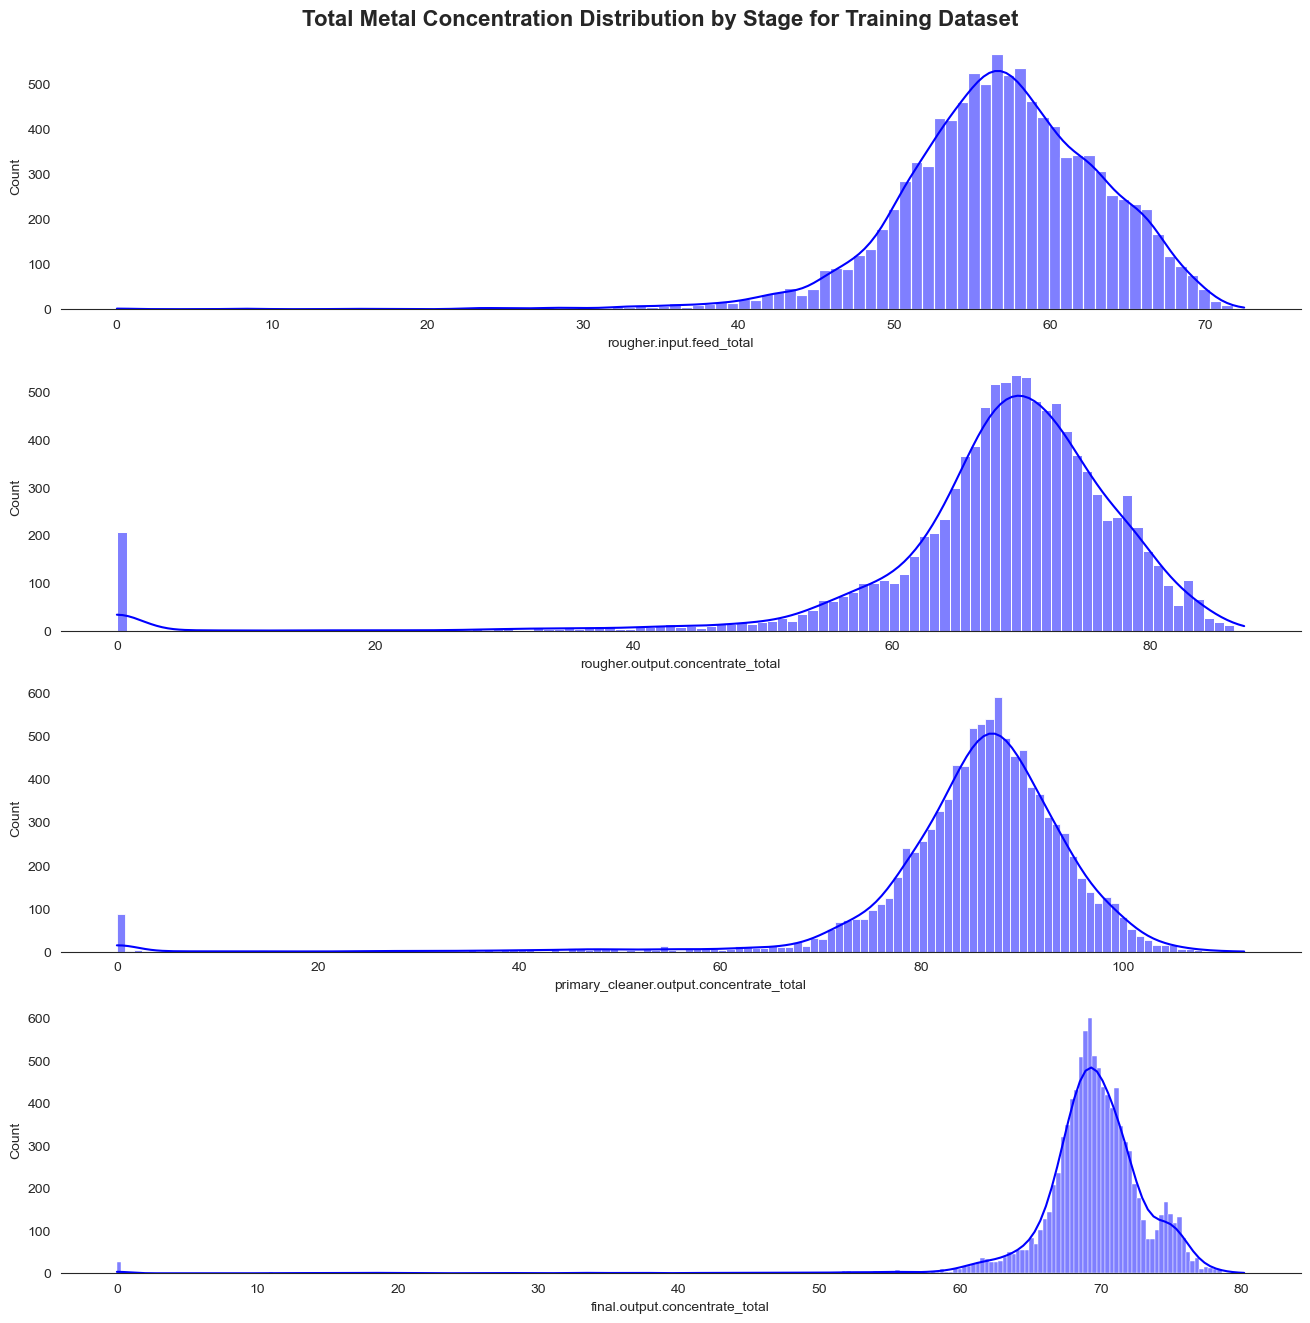

In [55]:
hist_plot2(df_train_no_outliers,cols,'Total Metal Concentration Distribution by Stage for Training Dataset')

In [56]:
lb0, ub0 = calc_bound(df_train_no_outliers[cols[0]])
lb1, ub1 = calc_bound(df_train_no_outliers[cols[1]])
lb2, ub2 = calc_bound(df_train_no_outliers[cols[2]])
lb3, ub3 = calc_bound(df_train_no_outliers[cols[3]])

print(f'Rougher input feed total for training dataset has lower bound = {lb0:.2f} and upper bound = {ub0:.2f}')
print(f'Rougher output concentrate total for training dataset has lower bound = {lb1:.2f} and upper bound = {ub1:.2f}')
print(f'Primary cleaner output concentrate total for training dataset has lower bound = {lb2:.2f} and upper bound = {ub2:.2f}')
print(f'Final output concentrate total for training dataset has lower bound = {lb3:.2f} and upper bound = {ub3:.2f}')

Rougher input feed total for training dataset has lower bound = 41.05 and upper bound = 73.22
Rougher output concentrate total for training dataset has lower bound = 52.59 and upper bound = 86.94
Primary cleaner output concentrate total for training dataset has lower bound = 68.36 and upper bound = 104.50
Final output concentrate total for training dataset has lower bound = 62.72 and upper bound = 76.58


In [57]:
df_train_no_outliers = df_train_no_outliers[
    (df_train_no_outliers[cols[0]] > lb0) & (df_train_no_outliers[cols[0]] < ub0) &
    (df_train_no_outliers[cols[1]] > lb1) & (df_train_no_outliers[cols[1]] < ub1) &
    (df_train_no_outliers[cols[2]] > lb2) & (df_train_no_outliers[cols[2]] < ub2) &
    (df_train_no_outliers[cols[3]] > lb3) & (df_train_no_outliers[cols[3]] < ub3) ]

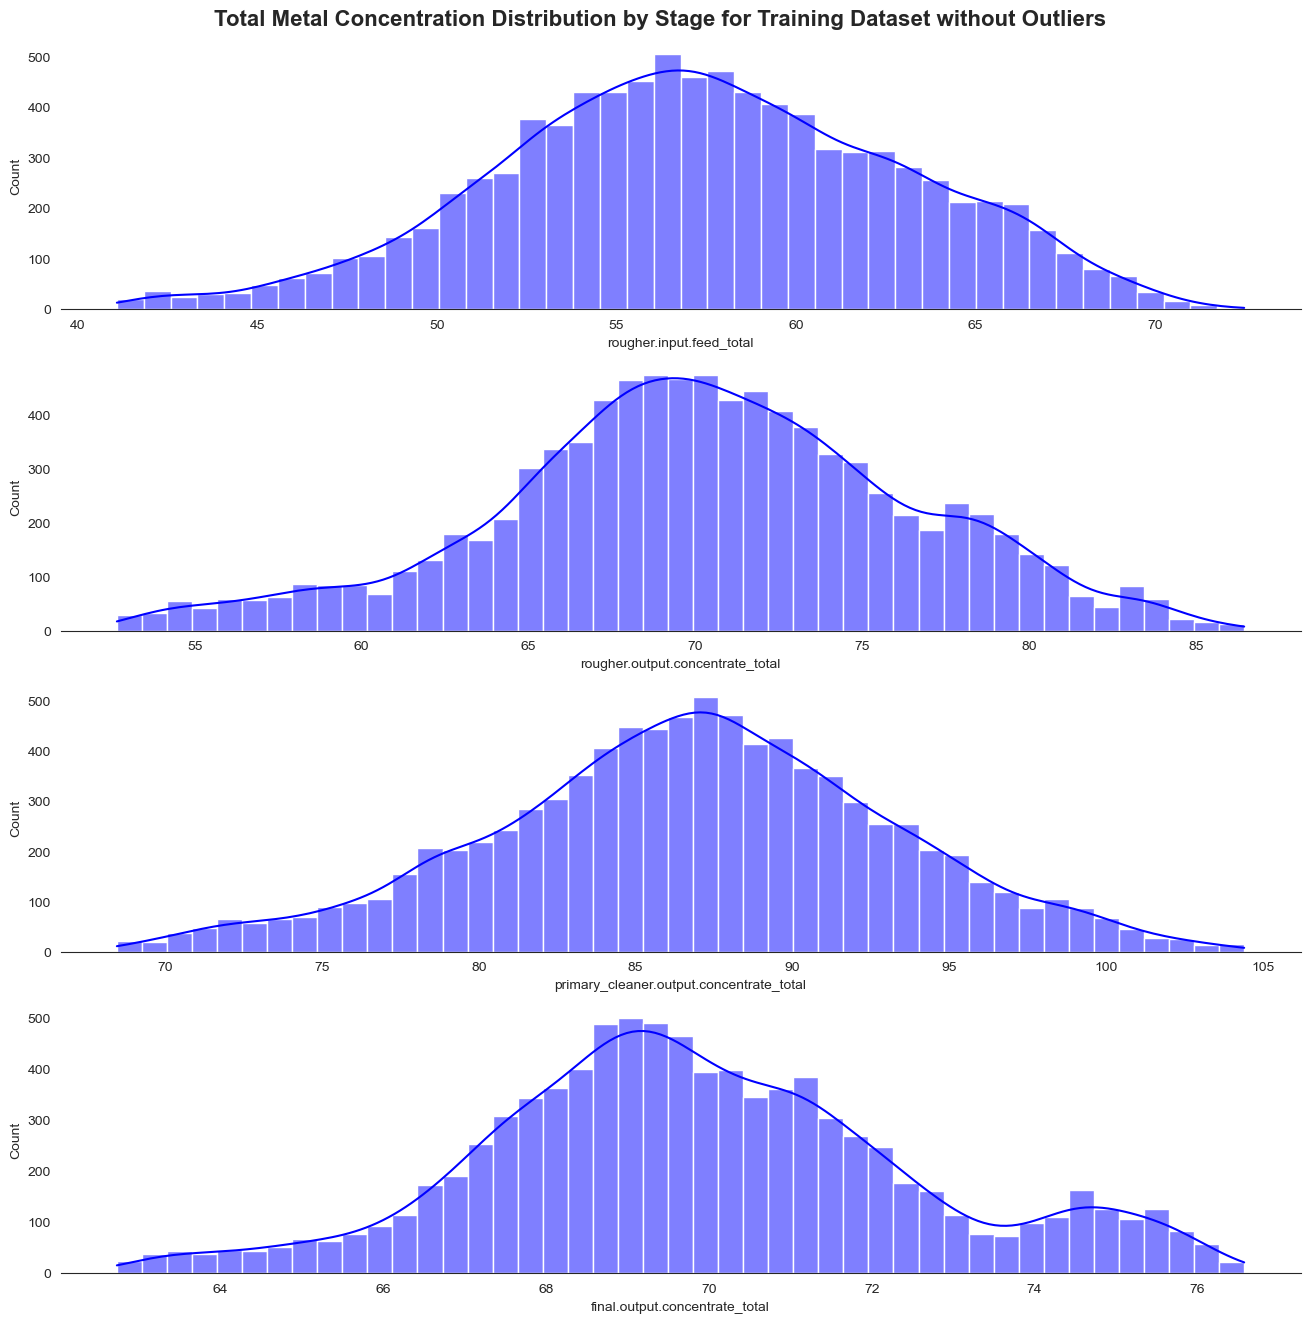

In [58]:
hist_plot2(df_train_no_outliers,cols,'Total Metal Concentration Distribution by Stage for Training Dataset without Outliers')

In [59]:
print('The resulting training dataset has {} rows and {} columns'.format(df_train_no_outliers.shape[0],df_train_no_outliers.shape[1])) 

The resulting training dataset has 8886 rows and 91 columns


#### Testing Dataset

In [60]:
df_test_no_outliers['rougher.input.feed_total'] =  df_test_no_outliers['rougher.input.feed_au'] + \
                                                    df_test_no_outliers['rougher.input.feed_ag'] + \
                                                    df_test_no_outliers['rougher.input.feed_pb'] + \
                                                    df_test_no_outliers['rougher.input.feed_sol']

C:\Users\Anglo\AppData\Local\Temp\ipykernel_5836\2984698630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_no_outliers['rougher.input.feed_total'] =  df_test_no_outliers['rougher.input.feed_au'] + \


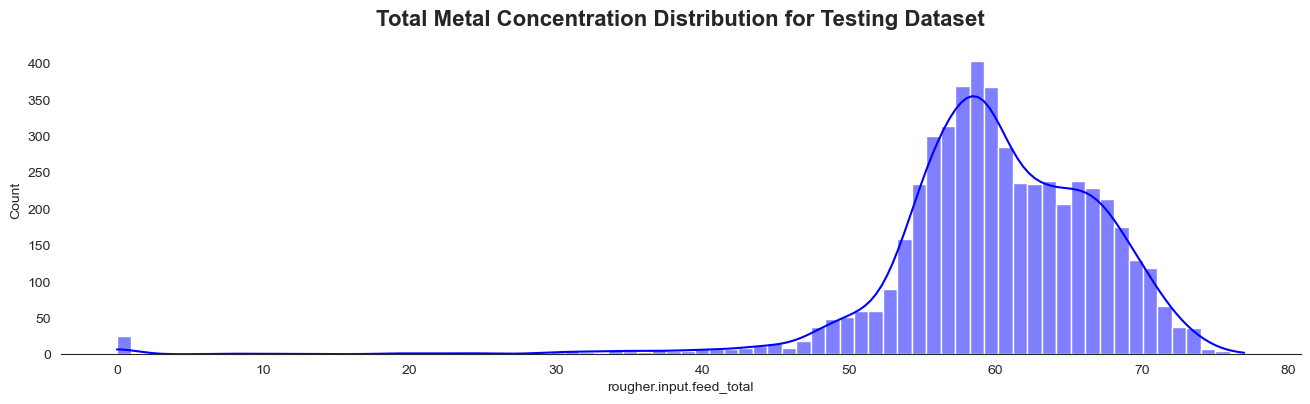

In [61]:
fig, ax = plt.subplots(figsize=(16,4))
sns.despine(left=True)
sns.histplot(df_test_no_outliers['rougher.input.feed_total'], kde=True, color='blue', alpha=0.5)
ax.set_xlabel('rougher.input.feed_total')
ax.set_title('Total Metal Concentration Distribution for Testing Dataset',y=1.04,fontsize=16,fontweight=700)
plt.show()

In [62]:
lb4, ub4 = calc_bound(df_test_no_outliers['rougher.input.feed_total'])

print(f'Rougher input feed total for testing dataset has lower bound = {lb4:.2f} and upper bound = {ub4:.2f}')

Rougher input feed total for testing dataset has lower bound = 43.52 and upper bound = 77.97


In [63]:
df_test_no_outliers = df_test_no_outliers[(df_test_no_outliers['rougher.input.feed_total'] > lb4) & (df_test_no_outliers['rougher.input.feed_total'] < ub4)]

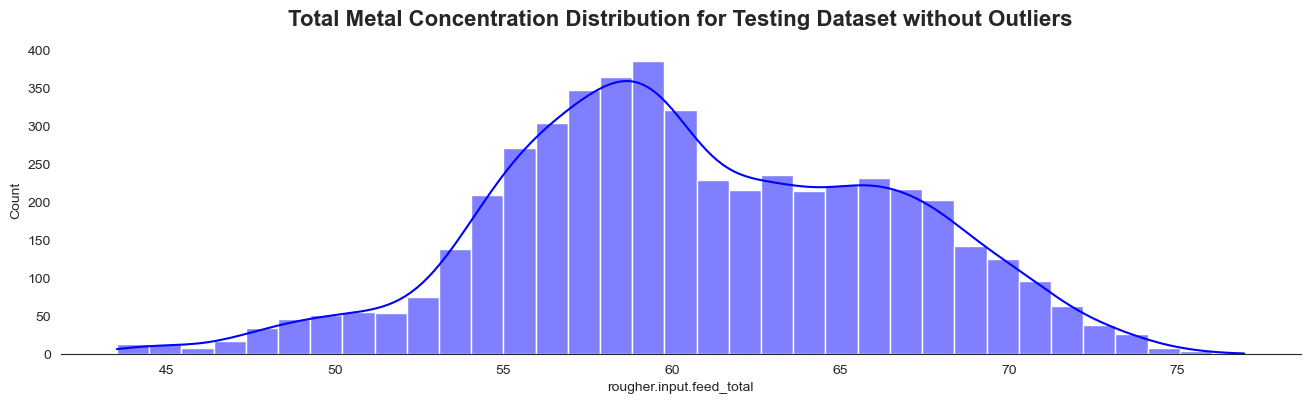

In [64]:
fig, ax = plt.subplots(figsize=(16,4))
sns.despine(left=True)
sns.histplot(df_test_no_outliers['rougher.input.feed_total'], kde=True, color='blue', alpha=0.5)
ax.set_xlabel('rougher.input.feed_total')
ax.set_title('Total Metal Concentration Distribution for Testing Dataset without Outliers',y=1.04,fontsize=16,fontweight=700)
plt.show()

In [65]:
print('The resulting testing dataset has {} rows and {} columns'.format(df_test_no_outliers.shape[0],df_test_no_outliers.shape[1]))

The resulting testing dataset has 4998 rows and 54 columns


[back to table of contents](#back)

## 5. Model Development <a id='train'></a>

### 5.1. sMAPE Function <a id='1'></a>

In [66]:
def calc_smape(target, predicted):
    numerator = abs(target - predicted)
    denominator = ((abs(target)+abs(predicted))/2)
    smape = np.mean(numerator / denominator)*100
    return smape

In [67]:
def calc_final_smape(smape_rougher,smape_final):
    final_smape = 0.25*smape_rougher + 0.75*smape_final
    return final_smape

<img src="https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved_smape_1576238825_1589899257.jpg" alt="image" class="image image_expandable">

[back to table of contents](#back)

### 5.2. Defining Features and Targets <a id='2'></a>

Listing columns to be dropped for training dataset.

In [68]:
dropped_train_cols = train_test_diff + ['date','rougher.input.feed_total', 'rougher.output.concentrate_total', 'primary_cleaner.output.concentrate_total', 'final.output.concentrate_total']

Merge available values for testing dataset output from full dataset.

In [69]:
df_test_no_outliers = df_test_no_outliers.merge(
    df_full[['date','rougher.output.recovery','final.output.recovery']], on='date', how='inner')

df_test_no_outliers.dropna()

df_test_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4804 entries, 0 to 4803
Data columns (total 56 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4804 non-null   object 
 1   primary_cleaner.input.sulfate               4804 non-null   float64
 2   primary_cleaner.input.depressant            4804 non-null   float64
 3   primary_cleaner.input.feed_size             4804 non-null   float64
 4   primary_cleaner.input.xanthate              4804 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      4804 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    4804 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      4804 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    4804 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      4804 non-null   float64
 10  primary_clea

Defining features and targets for supervised learning.

In [70]:
train_features = df_train_no_outliers.drop(dropped_train_cols,axis=1)
train_rougher_target = df_train_no_outliers['rougher.output.recovery']
train_final_target = df_train_no_outliers['final.output.recovery']

In [71]:
test_features = df_test_no_outliers.drop(['date','rougher.input.feed_total','rougher.output.recovery','final.output.recovery'],axis=1)
test_rougher_target = df_test_no_outliers['rougher.output.recovery']
test_final_target = df_test_no_outliers['final.output.recovery']

[back to table of contents](#back)

### 5.3. Build Model <a id='3'></a>

Train different models and evaluate these models using cross-validation. Choose the best model and test it using the test sample. Show what you have found.

#### Standardize Feature Values

Standardize features values so that every feature has similar scale.

In [72]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

#### Linear Regression

In [73]:
smape = make_scorer(calc_smape, greater_is_better = False)

In [74]:
model_lr_rougher = LinearRegression()
scores_lr_rougher = cross_val_score(model_lr_rougher,train_features,train_rougher_target,cv=5,scoring=smape)
cv_score_lr_rougher = abs(np.mean(scores_lr_rougher))
print(f'Rougher sMAPE for training set = {cv_score_lr_rougher:.2f} %')

model_lr_second = LinearRegression()
scores_lr_second = cross_val_score(model_lr_second,train_features,train_final_target,cv=5,scoring=smape)
cv_score_lr_second = abs(np.mean(scores_lr_second))
print(f'Final sMAPE for training set = {cv_score_lr_second:.2f} %')

overall_lr_second = calc_final_smape(cv_score_lr_rougher,cv_score_lr_second)
print(f'Overall sMAPE for training set = {overall_lr_second:.2f} %')

Rougher sMAPE for training set = 6.86 %
Final sMAPE for training set = 9.34 %
Overall sMAPE for training set = 8.72 %


In [75]:
model_lr_rougher.fit(train_features, train_rougher_target)
predicted_lr_rougher = model_lr_rougher.predict(test_features)
smape_score_lr_rougher = calc_smape(test_rougher_target, predicted_lr_rougher)
print(f'Rougher sMAPE for test set = {smape_score_lr_rougher:.2f} %')

model_lr_second.fit(train_features, train_final_target)
predicted_lr_second = model_lr_second.predict(test_features)
smape_score_lr_second = calc_smape(test_final_target, predicted_lr_second)
print(f'Final sMAPE for test set = {smape_score_lr_second:.2f} %')

overall_lr_second_t = calc_final_smape(smape_score_lr_rougher,smape_score_lr_second)
print(f'Overall sMAPE for test set = {overall_lr_second_t:.2f} %')

Rougher sMAPE for test set = 8.41 %
Final sMAPE for test set = 7.87 %
Overall sMAPE for test set = 8.00 %


#### Random Forest Regressor

Optimizing hyperparameter:

In [76]:
best_cv_score_rfr_rougher = 0
best_cv_score_rfr_second = 0
best_overall_rfr_second = np.inf
best_depth = 0
best_est = 0

for est in range(1,30,10):
    for depth in range(1,20,1):
        model_rfr_rougher = RandomForestRegressor(random_state=state, max_depth=depth, n_estimators=est)
        scores_rfr_rougher = cross_val_score(model_rfr_rougher,train_features,train_rougher_target,cv=5,scoring=smape)
        cv_score_rfr_rougher = abs(np.mean(scores_rfr_rougher))

        model_rfr_second = RandomForestRegressor(random_state=state, max_depth=depth, n_estimators=est)
        scores_rfr_second = cross_val_score(model_rfr_second,train_features,train_final_target,cv=5,scoring=smape)
        cv_score_rfr_second = abs(np.mean(scores_rfr_second))
        
        overall_rfr_second = calc_final_smape(cv_score_rfr_rougher,cv_score_rfr_second)
        if overall_rfr_second < best_overall_rfr_second:
            best_cv_score_rfr_rougher = cv_score_rfr_rougher
            best_cv_score_rfr_second = cv_score_rfr_second
            best_overall_rfr_second = overall_rfr_second
            best_depth = depth
            best_est = est


print(f'Best max depth for training set = {best_depth}')
print(f'Best n estimators = {best_est}')

print(f'Rougher sMAPE for training set = {best_cv_score_rfr_rougher:.2f} %')
print(f'Final sMAPE for training set = {best_cv_score_rfr_second:.2f} %')
print(f'Overall sMAPE for training set = {best_overall_rfr_second:.2f} %')

Best max depth for training set = 1
Best n estimators = 11
Rougher sMAPE for training set = 6.65 %
Final sMAPE for training set = 7.73 %
Overall sMAPE for training set = 7.46 %


Defining best model:

In [77]:
model_rfr_rougher = RandomForestRegressor(random_state=state, max_depth=best_depth, n_estimators=best_est)
model_rfr_rougher.fit(train_features, train_rougher_target)

model_rfr_second = RandomForestRegressor(random_state=state, max_depth=best_depth, n_estimators=best_est)
model_rfr_second.fit(train_features, train_rougher_target)

RandomForestRegressor(max_depth=1, n_estimators=11,
                      random_state=RandomState(MT19937) at 0x2469C43B340)

In [78]:
predicted_rfr_rougher = model_lr_rougher.predict(test_features)
smape_score_rfr_rougher = calc_smape(test_rougher_target, predicted_rfr_rougher)
print(f'Rougher sMAPE for test set = {smape_score_rfr_rougher:.2f} %')

predicted_rfr_second = model_lr_second.predict(test_features)
smape_score_rfr_second = calc_smape(test_final_target, predicted_rfr_second)
print(f'Final sMAPE for test set = {smape_score_rfr_second:.2f} %')

overall_rfr_second_t = calc_final_smape(smape_score_rfr_rougher,smape_score_rfr_second)
print(f'Overall sMAPE for test set = {overall_rfr_second_t:.2f} %')

Rougher sMAPE for test set = 8.41 %
Final sMAPE for test set = 7.87 %
Overall sMAPE for test set = 8.00 %


#### Dummy Regressor

In [79]:
model_dr_rougher = DummyRegressor(strategy='mean')
model_dr_rougher.fit(train_features, train_rougher_target)
predicted_dr_rougher = model_dr_rougher.predict(test_features)
smape_score_rfr_rougher = calc_smape(test_rougher_target, predicted_dr_rougher)
print(f'Rougher sMAPE for test set = {smape_score_rfr_rougher:.2f} %')

model_dr_second = DummyRegressor(strategy='mean')
model_dr_second.fit(train_features, train_final_target)
predicted_dr_second = model_dr_second.predict(test_features)
smape_score_rfr_second = calc_smape(test_final_target, predicted_dr_second)
print(f'Final sMAPE for test set = {smape_score_rfr_rougher:.2f} %')

overall_lr_second = calc_final_smape(smape_score_rfr_rougher,smape_score_rfr_second)
print(f'Overall sMAPE for test set = {overall_lr_second:.2f} %')

Rougher sMAPE for test set = 9.08 %
Final sMAPE for test set = 9.08 %
Overall sMAPE for test set = 8.56 %


[back to table of contents](#back)

## 6. General Conclusion <a id='end'></a>

We start the research by exploring the datasets. The full dataset consists of 22716 rows and 87 columns with 5856 rows goes to testing dataset and the rest goes to training dataset. Output and calculation variables are not found in testing dataset so that the testing dataset. Missing values are treated with **listwise deletion** because we need all the variables present to train the model. By manually calculating recovery rate for floatation process, we found that the recovery rate that is given is already representative as the **MAE** between those two values are very small, **9.5 x e-15**.

By plotting the mean or median of the metal concentration, we can see that the concentration of **Au increases steadily by 11-12%** in each stage until it reaches the final stage. Whereas the concentration of **Ag increases after the first step (floatation) and decreases slightly after**. For **Pb, the concentration increases in each stage, but the increase is getting smaller as the process continues**.

By removing feed particle size outliers using **1.5 IQR rule**, we get more representative values for the variables. By plotting and testing hypothesis on feed size for floatation and primary cleaner stages, we found that **the distributions are the same between feed size for training and testing dataset**. Next, we remove total substance concentration outliers for each stage in both training and testing dataset.

After removing all relevant outliers, we then define the sMAPE function to evaluate the resulting models with **25% weight on floatation output and 75% weight on final output**. In order to build a fair model, every feature column in training and testing datasets are **standardized**. After that we build linear regression model and random forest regressor model. For the linear model, the Overall sMAPE for training set is **8.72%** and for the test set is **8.00%**. This model performs better for test set so there is **no overfitting**. The random forest regressor model has the Overall sMAPE for training set is **7.45%** and for the test set is **8.00%**. This indicates **overfitting**. Comparing those two models, the **best model** to predict recovery rate is **the random forest regressor** with **max_depth = 1** and **n_estimators = 21**. Compared to dummy regressor using mean, the best model **outperforms** the dummy regressor therefore it is sound to be used for future predictions.

[back to table of contents](#back)

## 7. Appendix <a id='index'></a>

### Process Description

In order to gain pure gold, mined ores are processed through these steps.
1. The mined ore undergoes primary processing to obtain a gold ore mixture;
2. The resulting mixture then undergoes floatation process to obtain rougher concentrate;
3. Rougher concentrate particles produced from flotation then undergo two-stage purification process.

<img src="https://practicum-content.s3.us-west-1.amazonaws.com:443/resources/10.3.2ID_1673511127.png" alt="image" class="image image_expandable" style="">

**Flotation**:

The gold ore mixture is placed into a flotation tank to obtain gold concentrate (Au) and rougher tails (residue product with low levels of valuable metal concentration).

The stability of this process is influenced by the volatility and suboptimal physicochemical conditions of the flotation pulp (a mixture of solid particles and liquid).

**Purification**:

The rougher gold concentrate from the flotation process undergoes two stages of purification. After the purification process, we obtain the final gold concentrate with the desired level of metal concentration, as well as new rougher tails as residue product.

### Metrics

#### Calculation for Recovery

<img src="https://practicum-content.s3.us-west-1.amazonaws.com:443/resources/10.3.2.3ID_1673511227.png" alt="image" class="image image_expandable" style="">

* C - the percentage of gold in the concentrate immediately after the flotation process (to find the recovery of rougher concentrate)/after refining (to find the recovery of final concentrate)
* F - the percentage of gold in the feed before the flotation process (to find the recovery of rougher concentrate)/in the concentrate immediately after the flotation process (to find the recovery of final concentrate)
* T - the percentage of gold in the rougher tailings, immediately after the flotation process (to find the recovery of rougher concentrate)/after refining (to find the recovery of final concentrate)

To predict the coefficients, you need to find the percentage of gold in both the concentrate and tailings. Both the final concentrate and the rougher concentrate are equally important.

#### Evaluation Metric

sMAPE (symmetric Mean Absolute Percentage Error) is similar to MAE, but sMAPE is expressed in relative values, rather than absolute values. It is symmetric because sMAPE takes into account the scale of both the target and the prediction.

Here is the formula to calculate sMAPE:

<img src="https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved_smape_1576238825_1589899257.jpg" alt="image" class="image image_expandable">

The final metric used in this research includes 25% weighted rougher output recovery and 75% weighted final output recovery:

<img src="https://practicum-content.s3.us-west-1.amazonaws.com:443/resources/10.3.3ID_1673511358.png" alt="image" class="image image_expandable">

### Glossary

#### Technology Process

* Rougher feed — raw material for flotation process
* Rougher additions (or reagent additions) — reagents for flotation:
 * Xanthate — flotation activator or collector
 * Sulphate — sodium sulfide, specifically used for this process
 * Depressant — sodium silicate
* Rougher process — flotation
* Rougher tails — residue product
* Float banks — flotation units
* Cleaner process — purification
* Rougher Au — rougher gold concentrate
* Final Au — final gold concentrate

#### Available Stage Parameters

* air amount — air volume
* fluid levels
* feed size — feed particle size
* feed rate

[back to table of contents](#back)